# Results

Last updated: 27 February 2020

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel

In [2]:
climate = Climate() 
soil = Soil('loam')
crop = Crop(soil=soil)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
model.output()

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,doy,PD
0,0.3,0.75,1.000000,0.000000,0.300000,0.099097,0.099097,0.000000,0.0,-0.099097,1,100
1,0.3,0.75,1.000000,13.709485,0.299561,0.098010,0.098010,0.000000,0.0,13.611475,2,100
2,0.3,0.75,0.816272,0.000000,0.359922,0.280014,0.395841,0.115827,0.0,-0.395841,3,100
3,0.3,0.75,0.826536,6.007966,0.358166,0.273889,0.382920,0.109031,0.0,5.625046,4,100
4,0.3,0.75,0.686700,1.904871,0.383111,0.365042,0.570634,0.205592,0.0,1.334236,5,100
5,0.3,0.75,0.655431,0.000000,0.389028,0.387913,0.616409,0.228496,0.0,-0.616409,6,100
6,0.3,0.75,0.669786,0.000000,0.386295,0.377289,0.595204,0.217914,0.0,-0.595204,7,100
7,0.3,0.75,0.683795,0.000000,0.383655,0.367125,0.574822,0.207697,0.0,-0.574822,8,100
8,0.3,0.75,0.697462,0.000000,0.381106,0.357397,0.555226,0.197829,0.0,-0.555226,9,100
9,0.3,0.75,0.710792,8.155780,0.378644,0.348083,0.536381,0.188298,0.0,7.619398,10,100


In [3]:
# Bare soil evaporation
climate = Climate() 
soil = Soil('loam')
crop = Crop(soil=soil, T_max=0)
soil.set_nZr(crop)  
model = CropModel(crop=crop,soil=soil,climate=climate)

model.run()
#model.output()

## Finding the initial conditions

Why are we doing this? For each soil type and climatology, find the initial soil moisture value that is basically the value the time series converges to when you run many simulations.

These are the notes on what to do based on 19 February meeting with Kelly and Bryn

   * **Step 1.** Start DOY before the planting season. Pick a day when there isn’t much rain: July 1. Or pick some other day that’s verified it doesn’t rain much. 
   * **Step 2.** Run t_sim for 365 so the calendar ends on June 30. 
   * **Step 3.** Start planting date on Oct. 1
   * **Step 4.** Return just the soil moisture in a dataframe and append the simulation number to x
   * **Step 5.** Re-run the simulation where the soil moisture on July 1st is the value that ended on June 30. 
   * **Step 6.** Run this lots and lots of times. 
   * **Step 7.** Remove the first year of data because that was an artificial soil moisture value. 
   * **Step 8.** End goal: For a given day of the year, return the mean and variance of the soil moisture for that/each day. Plot the results.
   
The steps below do this with a stationary climatology (no changing alphas and lambdas.)

In [10]:
def initial_conditions(simulations, sm0=0.3):
    
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    
    # run this many times
    for i in range(simulations):
        
        # Step 1.  Start DOY before the planting season. 
        # Pick a day when there isn’t much rain: July 1, Julian Day 182 in non-leap year.

        # Step 2. Run t_sim for 365 so that calendar ends on June 30.
        new_climate = {
            'alpha_r': [10.0] * 12,
            'lambda_r': [0.25] * 12,
            'doy_start': 182,
            't_sim': 365,
            'ET_max': 6.5
        } 
        climate = Climate(climate_parameters=new_climate) 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  

        # Step 3. Start planting date on some reasonable planting date
        # Picked October 1. Julian Day 274 in regular year. 
        model = CropModel(crop=crop,soil=soil,climate=climate, planting_date=274)
        model.run(s0=sm0)
        fin = model.output()
        
        # Step 4. Return just the soil moisture in a dataframe and append the simulation
        # number to x
        df['x_' + str(i)] = model.s
        
        # Step 5. Take the soil moisture of June 30 and 
        # Re-run the simulation where the soil moisture on July 1st is the value that ended on June 30. 
        #print(fin.s.tail(1)) # The argument in tail is the last n lines
        sm0 = fin.s.tail(1)

    return df

# Step 6. Run this many times
result = initial_conditions(50)
result

100% (50 of 50) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_40,x_41,x_42,x_43,x_44,x_45,x_46,x_47,x_48,x_49
0,0.300000,0.507138,0.476563,0.662619,0.690000,0.562123,0.524974,0.539584,0.546202,0.512708,...,0.633684,0.716620,0.534502,0.435162,0.565995,0.471379,0.499960,0.535090,0.535590,0.553317
1,0.299561,0.499969,0.470606,0.649083,0.675652,0.552672,0.530950,0.531083,0.537425,0.505313,...,0.621085,0.690000,0.533910,0.430779,0.556378,0.465624,0.507742,0.526776,0.527256,0.544239
2,0.299126,0.500462,0.464881,0.635938,0.692324,0.543622,0.522808,0.522936,0.529014,0.498218,...,0.609054,0.675652,0.525646,0.426557,0.558999,0.460092,0.500548,0.518806,0.555444,0.535544
3,0.298696,0.493561,0.459377,0.623236,0.706174,0.648838,0.515001,0.515124,0.520952,0.491407,...,0.597560,0.661733,0.517722,0.444364,0.549681,0.454771,0.493644,0.511163,0.546277,0.527211
4,0.477662,0.486936,0.454084,0.618249,0.690000,0.635700,0.507513,0.509422,0.513221,0.484867,...,0.587225,0.648222,0.510124,0.439638,0.540757,0.449653,0.487015,0.596502,0.537496,0.519223
5,0.471663,0.480573,0.448992,0.606345,0.675652,0.681690,0.500329,0.502161,0.505805,0.501616,...,0.589942,0.658398,0.502834,0.435089,0.532207,0.444729,0.480649,0.585562,0.611246,0.511563
6,0.526128,0.494104,0.444093,0.594971,0.661733,0.667591,0.493433,0.500787,0.498690,0.572584,...,0.579290,0.644984,0.495838,0.490083,0.608952,0.452640,0.474533,0.623821,0.635115,0.536480
7,0.558253,0.487457,0.466489,0.584099,0.648946,0.653909,0.486813,0.493873,0.491860,0.562685,...,0.569101,0.646372,0.489122,0.601808,0.662312,0.447603,0.468656,0.611667,0.622451,0.621524
8,0.548966,0.481074,0.460923,0.574929,0.635805,0.642709,0.480455,0.576452,0.485302,0.553210,...,0.559352,0.659622,0.482672,0.590635,0.690000,0.442756,0.463006,0.600057,0.610359,0.614610
9,0.702742,0.474941,0.456780,0.564929,0.623110,0.629746,0.474346,0.573324,0.664210,0.544137,...,0.550018,0.646173,0.476477,0.579952,0.675652,0.438090,0.457574,0.685032,0.598807,0.602869


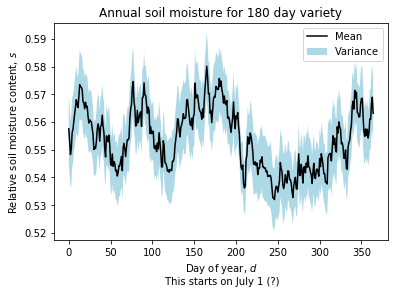

In [16]:
df = result

# Step 7. Remove the first year of data because that was an artificial soil moisture value. 
# So drop the first column (this needs to be out of the loop)
df = df.drop(['x_0'], axis=1)
    
# Step 8. End goal: For a given day of the year, return the mean and 
# variance of the soil moisture for that/each day. Plot the results.
df = result
df['mean'] = df.mean(axis=1)
df['var'] = df.var(axis=1)
df

# This is for one climatology and one maize variety (180 days)
plt.plot(df['mean'], 'k-')
x = np.arange(0, 365, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df['var']+df['mean'], df['mean']-df['var'],facecolor='lightblue') #, facecolor='lightsalmon'
plt.title('Annual soil moisture for 180 day variety')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of year, $\mathit{d}$ \n This starts on July 1 (?)')
plt.legend(['Mean', 'Variance'])
#plt.ylim(0.52, 0.62)

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


IndexError: tuple index out of range

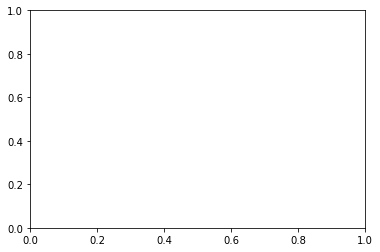

In [20]:
# make crazy plot
# this code is broken and is not what we want.
sim = 100
    
df = pd.DataFrame({'SIM':range(0,sim)})
    
fig = plt.figure()
    
for i, sm0 in enumerate(np.linspace(0,1.0,11)):
    # Run model 
    result = initial_conditions(sim,sm0)
    # Extract SM values for first day
    doy = result.iloc[0,:].reset_index(drop=True)
    df['SM_' + str(i)] = doy
        
    # Plot
    plt.plot(df.index,doy)
    
plt.xlabel('Simulation')
plt.ylabel('Soil moisture')
plt.legend(labels=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],bbox_to_anchor=(1.02,1), loc="upper left")
    

## Plot Growing Season Soil Moisture Availability

Why are we doing this? Once the correct initial soil moisture has been found for a particular soil type and climate, then use it to generate a time series. 

Notes on parameters chosen:

* MAM planting date: Julian day 100 (early April) 
* Rainfall climatology:  Used Ol Jogi rainfall conditions 
* Question about this: A rainfall climatology for a year or the summary for a station?

Steps 1-8 same as above.

100% (50 of 50) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


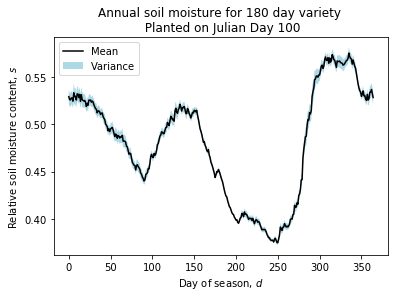

In [24]:
# Generate soil moisture for the whole year
def annual_sm(simulations, sm0=0.3):
    
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    
    # run this many times
    for i in range(simulations):
        
        # Step 1.  Start DOY before the planting season. 
        # Pick a day when there isn’t much rain: July 1, Julian Day 182 in non-leap year.

        # Step 2. Run t_sim for 365 so that calendar ends on June 30.
        new_climate = {
            'alpha_r': [9.247170,9.989583,10.586111,11.529771,9.157616,10.351128,10.967919,9.553691,9.254545,8.326368,8.137118,6.693333], 
            'lambda_r': [0.051808,0.051502,0.105572,0.272917,0.304435,0.138542,0.174395,0.150202,0.114583,0.209157,0.246237,0.093652], 
            'doy_start': 182,
            't_sim': 365,
            'ET_max': 6.5
        } 
        climate = Climate(climate_parameters=new_climate) 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  

        # Step 3. Start planting date on some reasonable planting date
        # Picked early April Julian Day 100 in regular year. 
        model = CropModel(crop=crop,soil=soil,climate=climate, planting_date=100)
        model.run(s0=sm0)
        fin = model.output()

        # Step 4
        df['x_' + str(i)] = fin.s
        
        # Step 5
        sm0 = fin.s.tail(1)

    return df 

result = annual_sm(50)
result

# Step 7. Remove the first year of data because that was an artificial soil moisture value. 
# So drop the first column (this needs to be out of the loop)

result = result.drop(['x_0'], axis=1)

# Step 8. End goal: For a given day of the year, return the mean and 
# variance of the soil moisture for that/each day. Plot the results.

df = result
df['mean'] = df.mean(axis=1)
df['var'] = df.var(axis=1)
df

# This is for one climatology and one maize variety (180 days)
plt.plot(df['mean'], 'k-')
x = np.arange(0, 365, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df['mean']+df['var'], df['mean']-df['var'],facecolor='lightblue') #, facecolor='lightblue'
plt.title('Annual soil moisture for 180 day variety \n Planted on Julian Day 100')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])
#plt.ylim(0.52, 0.62)

100% (50 of 50) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
/Users/charrua/miniconda3/envs/maize-Toff/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/charrua/miniconda3/envs/maize-Toff/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


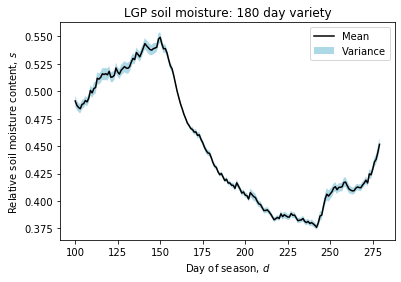

In [26]:
# Generate soil moisture during LGP
def lgp_sm(simulations, tstart = 0.5, tend = 0.75):
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # Step 1.  Start DOY before the planting season. 
        # Pick a day when there isn’t much rain: July 1, Julian Day 182 in non-leap year.

        # Step 2. Run t_sim for 365 so that calendar ends on June 30.
        new_climate = {
            'alpha_r': [9.247170,9.989583,10.586111,11.529771,9.157616,10.351128,10.967919,9.553691,9.254545,8.326368,8.137118,6.693333], 
            'lambda_r': [0.051808,0.051502,0.105572,0.272917,0.304435,0.138542,0.174395,0.150202,0.114583,0.209157,0.246237,0.093652], 
            'doy_start': 182,
            't_sim': 365,
            'ET_max': 6.5
        } 
        climate = Climate(climate_parameters=new_climate) 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  

        # Step 3. Start planting date on some reasonable planting date
        # Picked early April Julian Day 100 in regular year. 
        model = CropModel(crop=crop,soil=soil,climate=climate, planting_date=100)
        model.run()
        fin = model.output()
        
        # Step 4
        df['x_' + str(i)] = fin.s
        
        # Step 5
        sm0 = fin.s.tail(1)
        
    return df

result = lgp_sm(50)
result

# Step 7. Remove the first year of data because that was an artificial soil moisture value. 
# So drop the first column (this needs to be out of the loop)
result = result.drop(['x_0'], axis=1)

df = result

df = result.iloc[ 100:280 , : ]
df['mean'] = df.mean(axis=1)
df['var'] = df.var(axis=1)
df

# Plot some stuff
# This is for one climatology and one maize variety (180 days)
plt.plot(df['mean'], 'k-')
x = np.arange(100, 280, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df['var']+df['mean'], df['mean']-df['var'],facecolor='lightblue') #, facecolor='lightblue'
plt.title('LGP soil moisture: 180 day variety')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])


100% (1000 of 1000) |####################| Elapsed Time: 0:00:22 Time:  0:00:22


160
190


/Users/charrua/miniconda3/envs/maize-Toff/lib/python3.7/site-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/charrua/miniconda3/envs/maize-Toff/lib/python3.7/site-packages/ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


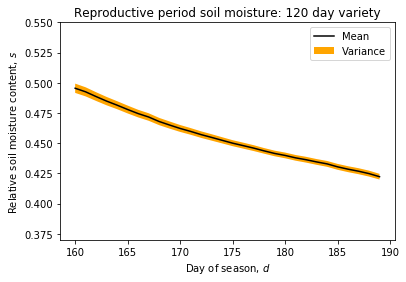

In [3]:
# Generate soil moisture during plateau of crop coefficient (reproductive period)

def rep_sm(simulations, tstart = 0.5, tend = 0.75):
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    result = []
    
    tseas =  120
    plantd = 100
    
    # run this many times
    for i in range(simulations):
        
        # Step 1.  Start DOY before the planting season. 
        # Pick a day when there isn’t much rain: July 1, Julian Day 182 in non-leap year.

        # Step 2. Run t_sim for 365 so that calendar ends on June 30.
        new_climate = {
            'alpha_r': [9.247170,9.989583,10.586111,11.529771,9.157616,10.351128,10.967919,9.553691,9.254545,8.326368,8.137118,6.693333], 
            'lambda_r': [0.051808,0.051502,0.105572,0.272917,0.304435,0.138542,0.174395,0.150202,0.114583,0.209157,0.246237,0.093652], 
            'doy_start': 182,
            't_sim': 365,
            'ET_max': 6.5
        } 
        climate = Climate(climate_parameters=new_climate) 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  

        # Step 3. Start planting date on some reasonable planting date
        # Picked early April Julian Day 100 in regular year. 
        model = CropModel(crop=crop,soil=soil,climate=climate, planting_date=100)
        model.run()
        fin = model.output()
        fin

        # Step 4. Take the soil moisture of June 30 and 
        # Re-run the simulation where the soil moisture on July 1st is the value that ended on June 30. 
        #print(fin.s.tail(1)) # The argument in tail is the last n lines
        last_s = fin.s.tail(1)

        # Step 5. Re-run the simulation where the soil moisture on July 1st is the value that ended on June 30. 
        # To do this we want to set s0 in model.run as last_s
        model.run(s0=last_s)
        fin = model.output()
        fin
        
        # Step 6. Run this lots and lots of times and return a matrix where the
        # row is each simulation and the column is doy
        
        # Return just the soil moisture in a dataframe and append the simulation
        # number to x
        df['x_' + str(i)] = model.s
        
    # Step 7. Remove the first year of data because that was an artificial soil moisture value. 
    # So drop the first column (this needs to be out of the loop)
    df = df.drop(['x_0'], axis=1)
    
    # Add the code back in with start and end that selects the rows we want
    # just select the part of the growing season that we want

    # Select certain rows; need to account for the fact that there's a planting date
    start = int(tseas*tstart+plantd)
    end = int(tseas*tend+plantd)
    print(start)
    print(end)
    df_ = df.iloc[ start:end , : ]
        
    # Take average soil moisture across each day
    df_['mean'] = df_.mean(axis=1)
    df_['var'] = df_.var(axis=1)
    
    return df_, start, end

df, start, end = rep_sm(1000)
df

# Plot some stuff
# This is for one climatology and one maize variety (180 days)
plt.plot(df['mean'], 'k-')
x = np.arange(start, end, 1) 

plt.fill_between(x, df['var']+df['mean'], df['mean']-df['var'],facecolor='orange') #, facecolor='lightblue', orange
plt.title('Reproductive period soil moisture: 120 day variety')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])
plt.ylim(0.37, 0.55)

plt.savefig('../output/figures/AvgRepSM_120d.pdf', format='pdf')

# Save the data as a csv
df.to_csv('../output/dataframes/AvgRepSM_120d.csv', sep=',')

## Old Functions

In [4]:
# Average soil moisture during interval of the season
# What this is doing is basically the same as my code before and just returning 
# the average soil moisture values during the "growing" part of the season. 

def avg_sm_gseason(simulations, tstart = 0.5, tend = 0.75):
    result = []

    climate = Climate() 
    soil = Soil('loam')
    crop = Crop(soil=soil)
    soil.set_nZr(crop)  
    model = CropModel(crop=crop,soil=soil,climate=climate)

    model.run()
    fin = model.output()

    for i in range(simulations):
        # This part is not really necessary
        # Tseas is 180 which is just what the model is set to 
        # create variable for DOY
        tseas = 120
        range_tseas = list(range(1,181,1))

        #print(model.s)
        fin['doy'] = range_tseas
        len(fin.doy)

        # Select certain rows
        start = int(tseas*tstart)
        end = int(tseas*tend)
        x = fin.s[start:end]
      
        # Add this value to a list
        result.append(x)
        
    # Make it a float
    return np.array(result, dtype=np.float32)

test = avg_sm_gseason(1000)

test.mean(), test.var()

(0.568378, 0.001018277)

In [5]:
def dist_avg_sm_gseason_daily(simulations, tstart = 0.5, tend = 0.75):
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # initialize objects
        climate = Climate() 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  
        model = CropModel(crop=crop,soil=soil,climate=climate)
        model.run()
        fin = model.output()
        
        # Return just the soil moisture in a dataframe
        df['x_' + str(i)] = model.s
        
        # just select the part of the growing season that we want
        tseas = 180

        # Select certain rows
        start = int(tseas*tstart)
        end = int(tseas*tend)
        _df = df[start:end]
        
        # Take average soil moisture across each day
        df2['mean'] = _df.mean(axis=1)
        df2['var'] = _df.var(axis=1)

    return _df, df2 #result

df, df2 = dist_avg_sm_gseason_daily(100)

100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


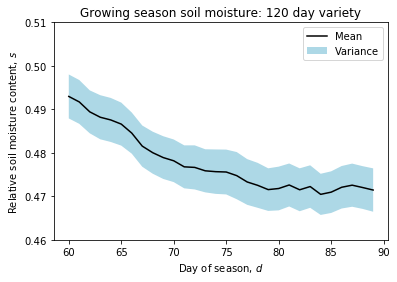

In [5]:
# Plot some stuff
# This is for one climatology and one maize variety (180 days)
plt.plot(df2['mean'], 'k-')
x = np.arange(60, 90, 1) #np.arange(90, 135, 1)

plt.fill_between(x, df2['var']+df2['mean'], df2['mean']-df2['var'],facecolor='lightblue') #, facecolor='lightblue'
plt.title('Growing season soil moisture: 120 day variety')
plt.ylabel('Relative soil moisture content, $\mathit{s}$')
plt.xlabel('Day of season, $\mathit{d}$')
plt.legend(['Mean', 'Variance'])
plt.ylim(0.46, 0.51)

# I'm not sure that this is correct but it's somethingt

plt.savefig('../output/figures/AvgGseasSM_120d.pdf', format='pdf')

# Save the data as a csv
df2.to_csv('../output/dataframes/AvgGseasSM_120d.csv', sep=',')
# 

In [18]:
def daily_sm(simulations):
    
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    df = pd.DataFrame()
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # initialize objects
        climate = Climate() 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  
        model = CropModel(crop=crop,soil=soil,climate=climate)
        model.run()

        # Return just the soil moisture in a dataframe
        df['x_' + str(i)] = model.s
        
        # Take average soil moisture across each day
        df['mean'] = df.mean(axis=1)
        df['var'] = df.var(axis=1)

    return df #result

fin = daily_sm(10)

100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [21]:
fin

,x_0,mean,var,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,0.300000,0.273180,0.007063,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000,0.300000
1,0.299561,0.282296,0.008003,0.312321,0.299561,0.299561,0.299561,0.309361,0.379615,0.299561,0.299561,0.299561
2,0.299126,0.287452,0.008306,0.311740,0.299126,0.316509,0.299126,0.308815,0.377203,0.299126,0.344546,0.299126
3,0.298696,0.286763,0.008247,0.311165,0.298696,0.315877,0.298696,0.308275,0.374873,0.298696,0.343286,0.298696
4,0.298271,0.298894,0.009743,0.321498,0.425167,0.315252,0.298271,0.307742,0.372622,0.298271,0.342065,0.298271
5,0.297850,0.299446,0.009666,0.320802,0.421151,0.314634,0.297850,0.324155,0.370446,0.297850,0.340883,0.297850
6,0.297434,0.301117,0.009772,0.322886,0.423837,0.333557,0.297434,0.323425,0.368343,0.297434,0.339738,0.297434
7,0.297023,0.310257,0.010717,0.326755,0.427466,0.332640,0.297023,0.322704,0.366310,0.297023,0.338629,0.405391
8,0.334962,0.312513,0.010578,0.325991,0.423366,0.331752,0.296615,0.321993,0.364345,0.296615,0.337555,0.402086
9,0.344296,0.319295,0.011025,0.377039,0.419415,0.330891,0.296213,0.321291,0.387442,0.296213,0.336514,0.398897


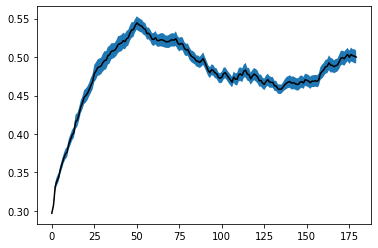

In [23]:
plt.plot(fin['mean'], 'k-')
x = np.arange(0.0, 180, 1)

plt.fill_between(x, fin['var']+fin['mean'], fin['mean']-fin['var'])
                 #v facecolor='red'
# I'm not sure that this is correct but it's somethingt

In [ ]:
def average_soil_moisture(simulations):
    
    # generate little progress bar
    import time
    import progressbar
    
    for i in progressbar.progressbar(range(simulations)):
        time.sleep(0.02)
    
    result = []
    
    # run this many times
    for i in range(simulations):
        
        # initialize objects
        climate = Climate() 
        soil = Soil('loam')
        crop = Crop(soil=soil)
        soil.set_nZr(crop)  
        model = CropModel(crop=crop,soil=soil,climate=climate)

        model.run()
        model.output()

        # Return average soil moisture
        x = model.s.mean()

        # Add this value to a list
        result.append(x)
        
    return result

# TODO: One enhancement
# Suppress done!

In [ ]:
fin = average_soil_moisture(simulations=1000)

In [ ]:
# This is the average and variance of soil moisture for the 10000s of simulations
import statistics
statistics.mean(fin)